In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.offline as pyo
import datetime
import matplotlib.dates as mdates

# YKD LAKE Model Benchmarking
This script is used to compare one or multiple LAKE model runs with obsereved water temperatures and concentrations of CO2 and CH4. The data preparation relies on LAKE model output in the second format option (output files ending in '1f2.dat').

In [2]:
def parse_layer_file(filepath):
    '''
    Read in LAKE model layers file 'layers 1 1.dat'

    Args:
    filepath (string): full filepath to layers file

    Output:
    layers (pd.DataFrame)
    '''
    layers=pd.read_csv(filepath, delimiter=r"\s+", skiprows=19, index_col=None, header=None)
    layers.columns=['year', 'month', 'day', 'hour', 'integration_time', 'water layer thickness, m', 
                           'W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                           'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m',
                           'ice layer thickness,   m', 'snow layer thickness,  m', 'bottom ice thickness,  m', 'reservoir volume,  m**3', 'volume deficit (accumulated),  m**3']
    layers['Date'] = pd.to_datetime({'Year': layers['year'], 'Month': layers['month'], 'Day':layers['day']})
    layers['mean_mixed_layer_thickness'] = layers[['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m']].mean(axis=1)
    layers['mean_lower_layer_thickness'] = layers[['W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m']].mean(axis=1)
    layers = layers.drop(columns = ['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                                    'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m'])
    layers['run_name'] = filepath.split('/')[-2]

    return layers

def parse_univariate_file(filepath, variable_name):
    '''
    Read in LAKE model univariate timeseries file in second format '{variable} 1 1f2.dat'. Outputs variable time series to pandas DataFrame.
    Expects first five columns are 'year', 'month', 'day', 'hour', and 'integration_time'
    --------------------------------------------------------------------------------------
    Tested for
    water temperature: filename = 'water_temp  1  1f2.dat'
    co2 conventation: filename = 'co2_water  1  1f2.dat'
    ch4 concentration: filename = 'methane_water  1  1f2.dat'
    o2 concentration: filename = 'oxygen_water  1  1f2.dat'
    doc concentration: filename = 'DOC  1  1f2.dat'
    --------------------------------------------------------------------------------------

    Args:
    filepath (string): full filepath to time series file
    vaeriable_name (string): name for time series variable column

    Output:
    layers (pd.DataFrame)
    '''
    
    file=pd.read_csv(filepath, delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    file.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', variable_name]
    file['Date'] = pd.to_datetime({'Year': file['year'], 'Month': file['month'], 'Day':file['day']})

    return file

def ppm_to_molarity(ppm, gas, T, P=1, Vh=60, Vb=160, temp_input = 'C'):
    # for headspace measurements
    # T in kelvin
    # assuming P = 1 atm
    # MW in g/mole
    
    if temp_input == 'C':
        T = T+273.15
    constants = {'ch4': {'H': 39769, 'MW': 16.04},
                 'o2': {'H': 43414, 'MW': 32},
                 'R': 1.98719}
    
    constants['ch4']['H'] = 1/(np.exp((-365.183 + 18106.7 / T + 49.7554 * np.log(T) + -0.00028503 * T) / constants['R']))
    constants['o2']['H'] = 1/(np.exp((-286.942 + 15450.6 / T + 36.5593 * np.log(T) + 0.01876620 * T) / constants['R']))
    
    Cg = (ppm*1e-6)
    pg = Cg * P #partial pressure of gas at atmospheric pressure (atm)
    CAH = 55.5 * (pg/constants[gas]['H']) * constants[gas]['MW'] + ((Vh/(Vb-Vh)) * Cg * (constants[gas]['MW']/22.4) * (273 / T)) #gas concentration in aqueous phase (g/L)

    return (CAH / constants[gas]['MW']) * 1e6 # umol gas / L water
    
def Vant_Hoff(T):
    #calculates Henry's law coefficient for CO2 at given temperature
    KHstar = 29
    kT_CO2 = 2400
    T_star = 298.15
    KH = KHstar * np.exp(kT_CO2*((1 / T) - (1 / T_star)))

    return KH
    
def ppm_to_molarity_co2(co2_ppm, T, sensor_depth=1, mean_air_pres = 100986, temp_input = 'C'):
    #for co2 sensor measurements
    p_hydrostatic = 1000 * 9.8 * sensor_depth #Pa
    co2_ppm_corr = co2_ppm * (mean_air_pres/(mean_air_pres+p_hydrostatic))

    pCO2 = co2_ppm_corr * (mean_air_pres+p_hydrostatic) * 1e-6
    
    if temp_input=='C':
        T = T+273.15
        
    KH = Vant_Hoff(T) * 101325

    MCO2 = (pCO2 / KH) #mol CO2 / L solution

    #MCO2 = MCO2 * 1000 #mol / m3
    
    return MCO2 * 1e6 #umol/L

In [3]:
datafile_names = {'layers': 'layers  1  1.dat',
                  'water_temp': 'water_temp  1  1f2.dat',
                  'soil_temp': 'soil_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat',
                  'o2_water': 'oxygen_water  1  1f2.dat',
                  'doc_water': 'DOC  1  1f2.dat',
                  'pocl_water': 'POCL  1  1f2.dat', #live POC
                  'pocd_water': 'POCD  1  1f2.dat',
                  'phosph_water': 'phosph_water  1  1f2.dat'} #dead POC

In [4]:
#paths_to_burned_LAKE_output = ['YKD-SA/YKD-burned/LAKE{}/results/YKD{}/time_series'.format(i,i) for i in range(0,100)]
#paths_to_burned_LAKE_output = paths_to_burned_LAKE_output[:4]+paths_to_burned_LAKE_output[5:]
paths_to_burned_LAKE_output = ['/home/amullen/Lake-Model-Data/model_output/YKD-met-exp/YKD-burned']

#paths_to_unburned_LAKE_output = ['YKD-SA/YKD-unburned/LAKE{}/results/YKD{}/time_series'.format(i,i) for i in range(0,100)]
#paths_to_unburned_LAKE_output = paths_to_unburned_LAKE_output[:4]+paths_to_unburned_LAKE_output[5:]
paths_to_unburned_LAKE_output = ['/home/amullen/Lake-Model-Data/model_output/YKD-met-exp/YKD-unburned']

path_to_burned_sample_matrix = 'YKD-SA/YKD-burned/sample_matrix.csv'
path_to_unburned_sample_matrix = 'YKD-SA/YKD-unburned/sample_matrix.csv'

In [5]:
burned_sample_matrix = pd.read_csv(path_to_burned_sample_matrix)
burned_sample_matrix = burned_sample_matrix.rename(columns = {'Unnamed: 0': 'run_name'})

unburned_sample_matrix = pd.read_csv(path_to_unburned_sample_matrix)
unburned_sample_matrix = unburned_sample_matrix.rename(columns = {'Unnamed: 0': 'run_name'})

In [6]:
path_to_unburned_co2_obs = '../data/raw/UB_Pond_CO2_062622-072822.csv'
path_to_burned_co2_obs = '../data/raw/Burned_Pond_CO2_062422-081622.csv'
path_to_ch4_obs = '../data/raw/Pond_Env_For_Elchin.xlsx'

In [7]:
unburned_co2_obs = pd.read_csv(path_to_unburned_co2_obs, parse_dates=['Date', 'Date.1'])
unburned_co2_obs = unburned_co2_obs.rename(columns={'Date': 'datetime', 'Date.1': 'Date', 
                                                    'CO2_High_ppm': 'CO2_meas_ppm', 'CO2_High_RA_ppm':'CO2_meas_RA_ppm',
                                                    'WaterTemp_degC': 'WaterTemp_meas_degC'})

unburned_co2_obs['CO2_mol_m3'] = ppm_to_molarity_co2(unburned_co2_obs['CO2_meas_ppm'], unburned_co2_obs['WaterTemp_meas_degC'])

min_ub_co2_date = unburned_co2_obs['Date'].min()
max_ub_co2_date = unburned_co2_obs['Date'].max()

burned_co2_obs = pd.read_csv(path_to_burned_co2_obs, parse_dates=['TIMESTAMP', 'Date'])
burned_co2_obs = burned_co2_obs.rename(columns={'TIMESTAMP': 'datetime', 'CO2_High_ppm': 'CO2_meas_ppm', 
                                                'CO2_High_RA_ppm':'CO2_meas_RA_ppm', 'WaterTemp_degC': 'WaterTemp_meas_degC'})
burned_co2_obs['CO2_mol_m3'] = ppm_to_molarity_co2(burned_co2_obs['CO2_meas_ppm'], burned_co2_obs['WaterTemp_meas_degC'])

min_bu_co2_date = burned_co2_obs['Date'].min()
max_bu_co2_date = burned_co2_obs['Date'].max()

In [8]:
ch4_obs = pd.read_excel(path_to_ch4_obs, parse_dates=['date'])
ch4_obs = ch4_obs.rename(columns={'date': 'Date'})
ch4_obs['CH4_mol_m3'] = ppm_to_molarity(ch4_obs['CH4_ppm'], 'ch4', ch4_obs['temp_C'])
ch4_obs['DO_mol_m3'] = ((ch4_obs['DO_mg_L'] / 1000) / 32) / 0.001
min_ch4_date = ch4_obs['Date'].min()
max_ch4_date = ch4_obs['Date'].max()

In [9]:
#get layer thickness df for burned runs
burned_layer_df = []
for out_path in paths_to_burned_LAKE_output:
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        burned_layer_df.append(parse_layer_file(os.path.join(out_path, datafile_names['layers'])))

burned_layer_df = pd.concat(burned_layer_df)

In [10]:
#get layer thickness df for unburned runs
unburned_layer_df = []
for out_path in paths_to_unburned_LAKE_output:
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        unburned_layer_df.append(parse_layer_file(os.path.join(out_path, datafile_names['layers'])))

unburned_layer_df = pd.concat(unburned_layer_df)

In [11]:
#get temp, co2, and ch4 df for burned runs
burned_vars_df = []
burned_soil_temps_df = []
for out_path in paths_to_burned_LAKE_output:
    #water temp
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        twater=parse_univariate_file(os.path.join(out_path, datafile_names['water_temp']), 't_water')
        tsoil=parse_univariate_file(os.path.join(out_path, datafile_names['soil_temp']), 't_soil')
        co2=parse_univariate_file(os.path.join(out_path, datafile_names['co2_water']), 'co2_water')
        ch4=parse_univariate_file(os.path.join(out_path, datafile_names['ch4_water']), 'ch4_water')
        o2=parse_univariate_file(os.path.join(out_path, datafile_names['o2_water']), 'o2_water')
        doc=parse_univariate_file(os.path.join(out_path, datafile_names['doc_water']), 'doc_water')
        pocl=parse_univariate_file(os.path.join(out_path, datafile_names['pocl_water']), 'pocl_water')
        pocd=parse_univariate_file(os.path.join(out_path, datafile_names['pocd_water']), 'pocd_water')
        phosph=parse_univariate_file(os.path.join(out_path, datafile_names['phosph_water']), 'phosph_water')
        poc=pocl['pocl_water']+pocd['pocd_water']
        
        var_df = pd.merge(twater, co2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, ch4, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, o2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, doc, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocl, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocd, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, phosph, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df['poc_water'] = poc
        
        #var_df['run_name'] = int(out_path.split('/')[-2][3:])
        #tsoil['run_name'] = int(out_path.split('/')[-2][3:])
        var_df['run_name'] = 0
        tsoil['run_name'] = 0
        
        burned_vars_df.append(var_df)
        burned_soil_temps_df.append(tsoil)

burned_vars_df = pd.concat(burned_vars_df)
burned_soil_temps_df = pd.concat(burned_soil_temps_df)

,year,month,day,hour,integration_time,depth,t_water,Date,co2_water,ch4_water,o2_water,doc_water,pocl_water,pocd_water,phosph_water,poc_water,run_name
11,2022,1,2,12.0,1.0,-1.0,3.110065,2022-01-02,153.939186,44.776788,0.000000e+00,2.193845e-08,4.028552e-02,0.059714,0.003100,0.100000,0
28,2022,1,3,12.0,2.0,-1.0,2.910465,2022-01-03,154.191914,45.654688,0.000000e+00,3.136005e-08,1.622925e-02,0.083771,0.003100,0.100000,0
45,2022,1,4,12.0,3.0,-1.0,2.770260,2022-01-04,154.369789,46.677502,0.000000e+00,3.596188e-08,6.538054e-03,0.093462,0.003100,0.100000,0
62,2022,1,5,12.0,4.0,-1.0,2.662292,2022-01-05,154.506963,47.840688,0.000000e+00,3.801319e-08,2.633899e-03,0.097366,0.003100,0.100000,0
79,2022,1,6,12.0,5.0,-1.0,2.575103,2022-01-06,154.617862,49.242910,0.000000e+00,3.888876e-08,1.061085e-03,0.098939,0.003100,0.100000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,2022,12,28,12.0,361.0,-1.0,3.734570,2022-12-28,192.170115,450.980639,4.198424e-10,1.175538e-01,2.505969e-14,10.420065,0.029551,10.420065,0
6148,2022,12,29,12.0,362.0,-1.0,3.724136,2022-12-29,192.183264,456.356664,0.000000e+00,1.175531e-01,2.952866e-14,10.398581,0.029576,10.398581,0
6165,2022,12,30,12.0,363.0,-1.0,3.712508,2022-12-30,192.198005,461.314856,0.000000e+00,1.175523e-01,3.550776e-14,10.377367,0.029603,10.377367,0
6182,2022,12,31,12.0,364.0,-1.0,3.688281,2022-12-31,192.231559,465.735912,4.331274e-10,1.175512e-01,3.950109e-14,10.356427,0.029638,10.356427,0


In [14]:
#get temp, co2, and ch4 df for burned runs
unburned_vars_df = []
unburned_soil_temps_df = []
for out_path in paths_to_unburned_LAKE_output:
    #water temp
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        twater=parse_univariate_file(os.path.join(out_path, datafile_names['water_temp']), 't_water')
        tsoil=parse_univariate_file(os.path.join(out_path, datafile_names['soil_temp']), 't_soil')
        co2=parse_univariate_file(os.path.join(out_path, datafile_names['co2_water']), 'co2_water')
        ch4=parse_univariate_file(os.path.join(out_path, datafile_names['ch4_water']), 'ch4_water')
        o2=parse_univariate_file(os.path.join(out_path, datafile_names['o2_water']), 'o2_water')
        doc=parse_univariate_file(os.path.join(out_path, datafile_names['o2_water']), 'doc_water')
        pocl=parse_univariate_file(os.path.join(out_path, datafile_names['pocl_water']), 'pocl_water')
        pocd=parse_univariate_file(os.path.join(out_path, datafile_names['pocd_water']), 'pocd_water')
        phosph=parse_univariate_file(os.path.join(out_path, datafile_names['phosph_water']), 'phosph_water')
        poc=pocl['pocl_water']+pocd['pocd_water']
        
        var_df = pd.merge(twater, co2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, ch4, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, o2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, doc, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocl, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocd, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, phosph, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df['poc_water'] = poc
        
        #var_df['run_name'] = int(out_path.split('/')[-2][3:])
        #tsoil['run_name'] = int(out_path.split('/')[-2][3:])
        var_df['run_name'] = 0
        tsoil['run_name'] = 0
        unburned_vars_df.append(var_df)
        unburned_soil_temps_df.append(tsoil)

unburned_vars_df = pd.concat(unburned_vars_df)
unburned_soil_temps_df = pd.concat(unburned_soil_temps_df)

In [16]:
time_min=pd.to_datetime('2022-06-01')
time_max=pd.to_datetime('2022-10-01')

In [17]:
#burned_vars_df = burned_vars_df.loc[(burned_vars_df['Date']> time_min) & (burned_vars_df['Date']< time_max)]
#unburned_vars_df = unburned_vars_df.loc[(unburned_vars_df['Date']> time_min) & (unburned_vars_df['Date']< time_max)]

In [18]:
burned_vars_df = pd.merge(burned_vars_df, burned_co2_obs, how = 'left', on=['Date'])
burned_vars_df = pd.merge(burned_vars_df, ch4_obs.loc[ch4_obs['sample']=='15B_FP'], how = 'left', on=['Date'])
unburned_vars_df = pd.merge(unburned_vars_df, unburned_co2_obs, how = 'left', on=['Date'])
unburned_vars_df = pd.merge(unburned_vars_df, ch4_obs.loc[ch4_obs['sample']=='UB_FP'], how = 'left', on=['Date'])

In [20]:
layers_burned = parse_layer_file(os.path.join(paths_to_burned_LAKE_output[0], datafile_names['layers']))
layers_burned = layers_burned.loc[:,['Date', 'water layer thickness, m', 'ice layer thickness,   m', 'snow layer thickness,  m', 'mean_mixed_layer_thickness', 'mean_lower_layer_thickness']]
layers_burned['ice_layer_height'] = layers_burned['ice layer thickness,   m'] + layers_burned['water layer thickness, m']
layers_burned['snow_layer_height'] = layers_burned['ice_layer_height'] + layers_burned['snow layer thickness,  m']

layers_unburned = parse_layer_file('YKD-SA/YKD-unburned/LAKE16/results/YKD16/time_series/{}'.format(datafile_names['layers']))
layers_unburned = layers_unburned.loc[:,['Date', 'water layer thickness, m', 'ice layer thickness,   m', 'snow layer thickness,  m', 'mean_mixed_layer_thickness', 'mean_lower_layer_thickness']]
layers_unburned['ice_layer_height'] = layers_unburned['ice layer thickness,   m'] + layers_unburned['water layer thickness, m']
layers_unburned['snow_layer_height'] = layers_unburned['ice_layer_height'] + layers_unburned['snow layer thickness,  m']

# Plotting
### Burned Plots

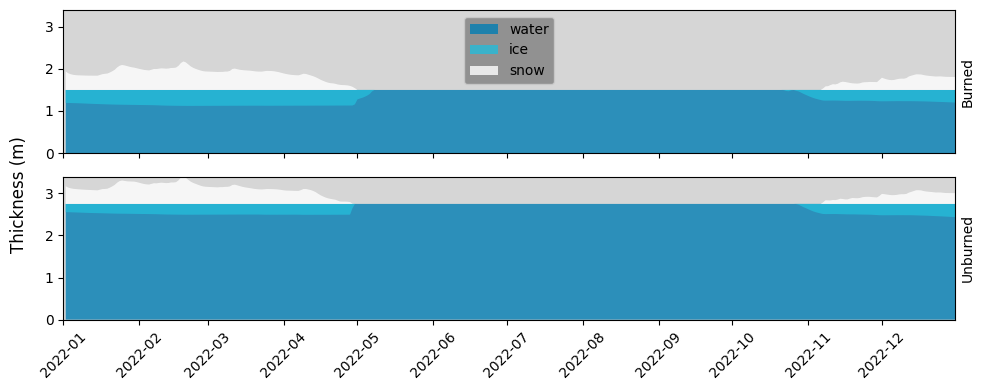

In [21]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True, sharey=True)


axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m'] - layers_burned['mean_mixed_layer_thickness'], layers_burned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[0].fill_between(layers_burned['Date'], 0, layers_burned['water layer thickness, m'],  
                facecolor ='#027eb3', alpha = 0.8, label='water')
axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m']-layers_burned['ice layer thickness,   m'], layers_burned['water layer thickness, m'],  
                facecolor ='#25bbd9', alpha = 0.8, label='ice')
axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m'], layers_burned['snow layer thickness,  m'] + layers_burned['water layer thickness, m'],  
                facecolor ='white', alpha = 0.8, label='snow')
axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m'] - layers_burned['mean_mixed_layer_thickness'], layers_burned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[0].set_facecolor('#d6d6d6')
#axes[0].set_ylim(0,2.3)

axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m'] - layers_unburned['mean_mixed_layer_thickness'], layers_unburned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], 0, layers_unburned['water layer thickness, m'],  
                facecolor ='#027eb3', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m']-layers_unburned['ice layer thickness,   m'], layers_unburned['water layer thickness, m'],  
                facecolor ='#25bbd9', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m'], layers_unburned['snow layer thickness,  m'] + layers_unburned['water layer thickness, m'],  
                facecolor ='white', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m'] - layers_unburned['mean_mixed_layer_thickness'], layers_unburned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[1].set_facecolor('#d6d6d6')
axes[0].legend(loc='upper center', facecolor = 'grey')

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")

plt.ylim(0, 3.4)
plt.xticks(rotation=45)
plt.xlim(pd.to_datetime('2022-01-01'),pd.to_datetime('2022-12-31'))
fig.supylabel('Thickness (m)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_layers.jpg', dpi=300)

In [22]:
layers_burned.loc[layers_burned['Date']=='2022-01-02']

,Date,"water layer thickness, m","ice layer thickness, m","snow layer thickness, m",mean_mixed_layer_thickness,mean_lower_layer_thickness,ice_layer_height,snow_layer_height
0,2022-01-02,1.4998,0.3074,0.439,0.0,0.0,1.8072,2.2462


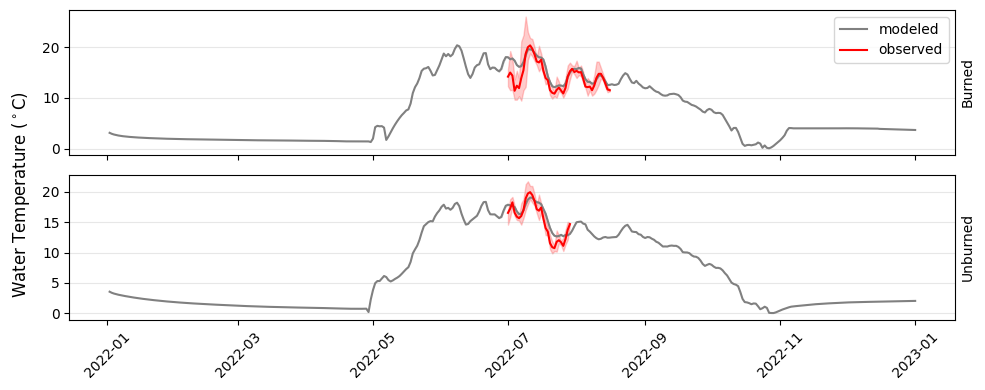

In [23]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df.loc[(burned_vars_df['run_name']==0)&(burned_vars_df['t_water']!=-999)& (burned_vars_df['depth']==-1)], 
             x='Date', y='t_water', label='modeled', ax=axes[0], color='grey')
sns.lineplot(data=burned_vars_df, x='Date', y='WaterTemp_meas_degC', label='observed', ax=axes[0], errorbar='pi', color='red')
#sns.scatterplot(data=burned_vars_df, x='Date', y='WaterTemp_meas_degC', ax=axes[0])

sns.lineplot(data= unburned_vars_df.loc[(unburned_vars_df['run_name']==0)&(unburned_vars_df['t_water']!=-999)& (unburned_vars_df['depth']==-1)], 
             x='Date', y='t_water', ax=axes[1], color='grey')
sns.lineplot(data=unburned_vars_df, x='Date', y='WaterTemp_meas_degC', ax=axes[1], errorbar='pi', color='red')
#sns.scatterplot(data=unburned_vars_df, x='Date', y='WaterTemp_meas_degC', ax=axes[1])



axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

plt.xticks(rotation=45)
fig.supylabel('Water Temperature ($^\circ$C)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_twater.jpg', dpi=300)

In [24]:
burned_soil_temps_df

,year,month,day,hour,integration_time,depth,t_soil,Date,run_name
0,2022,1,2,12.0,1.0,-0.0,3.9819,2022-01-02,0
1,2022,1,2,12.0,1.0,-1.0,5.5687,2022-01-02,0
2,2022,1,2,12.0,1.0,-2.0,6.6549,2022-01-02,0
3,2022,1,2,12.0,1.0,-3.0,7.2274,2022-01-02,0
4,2022,1,2,12.0,1.0,-4.0,7.3555,2022-01-02,0
...,...,...,...,...,...,...,...,...,...
4010,2023,1,1,12.0,365.0,-6.0,7.4076,2023-01-01,0
4011,2023,1,1,12.0,365.0,-7.0,7.2456,2023-01-01,0
4012,2023,1,1,12.0,365.0,-8.0,7.2186,2023-01-01,0
4013,2023,1,1,12.0,365.0,-9.0,7.2186,2023-01-01,0


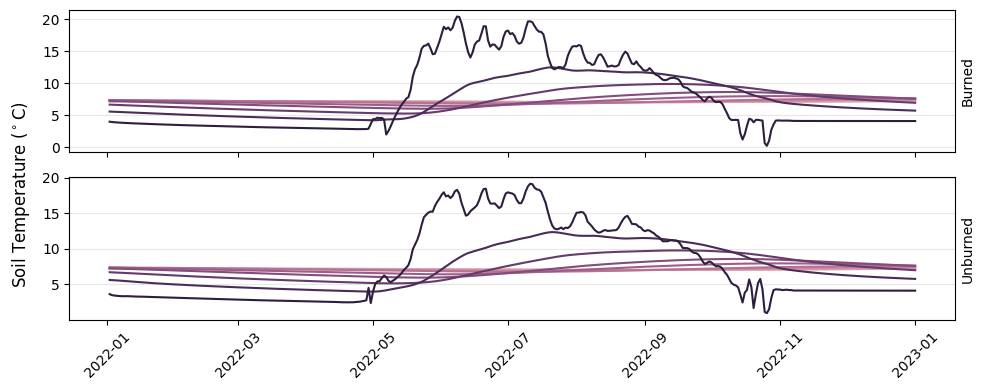

In [25]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_soil_temps_df.loc[(burned_soil_temps_df['run_name']==0)&(burned_soil_temps_df['t_soil']!=-999)], 
             x='Date', y='t_soil', label='modeled', ax=axes[0], hue='depth', legend=False)

sns.lineplot(data= unburned_soil_temps_df.loc[(unburned_soil_temps_df['run_name']==0)&(unburned_soil_temps_df['t_soil']!=-999)], 
             x='Date', y='t_soil', label='modeled', ax=axes[1], hue='depth', legend=False)

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

plt.xticks(rotation=45)
fig.supylabel('Soil Temperature ($^\circ$C)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_tsoil.jpg', dpi=300)

In [26]:
burned_vars_df

,year,month,day,hour,integration_time,depth,t_water,Date,co2_water,ch4_water,...,dD (VSMOW),a250,A254,a350,a375,S_275_295,S_R,SUVA,CH4_mol_m3,DO_mol_m3
0,2022,1,2,12.0,1.0,-0.00,-1.607966e-11,2022-01-02,157.944198,44.584034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,1,2,12.0,1.0,-0.05,1.798594e-01,2022-01-02,157.708668,44.601156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,1,2,12.0,1.0,-0.10,3.654102e-01,2022-01-02,157.466164,44.621375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,1,2,12.0,1.0,-0.15,5.529967e-01,2022-01-02,157.221495,44.642482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022,1,2,12.0,1.0,-0.20,7.388625e-01,2022-01-02,156.979658,44.660924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48173,2023,1,1,12.0,365.0,-1.20,4.007647e+00,2023-01-01,191.820335,516.475246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48174,2023,1,1,12.0,365.0,-1.40,4.021989e+00,2023-01-01,191.797828,516.952740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48175,2023,1,1,12.0,365.0,-1.50,-9.990000e+02,2023-01-01,-999.000000,-999.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48176,2023,1,1,12.0,365.0,-2.00,-9.990000e+02,2023-01-01,-999.000000,-999.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


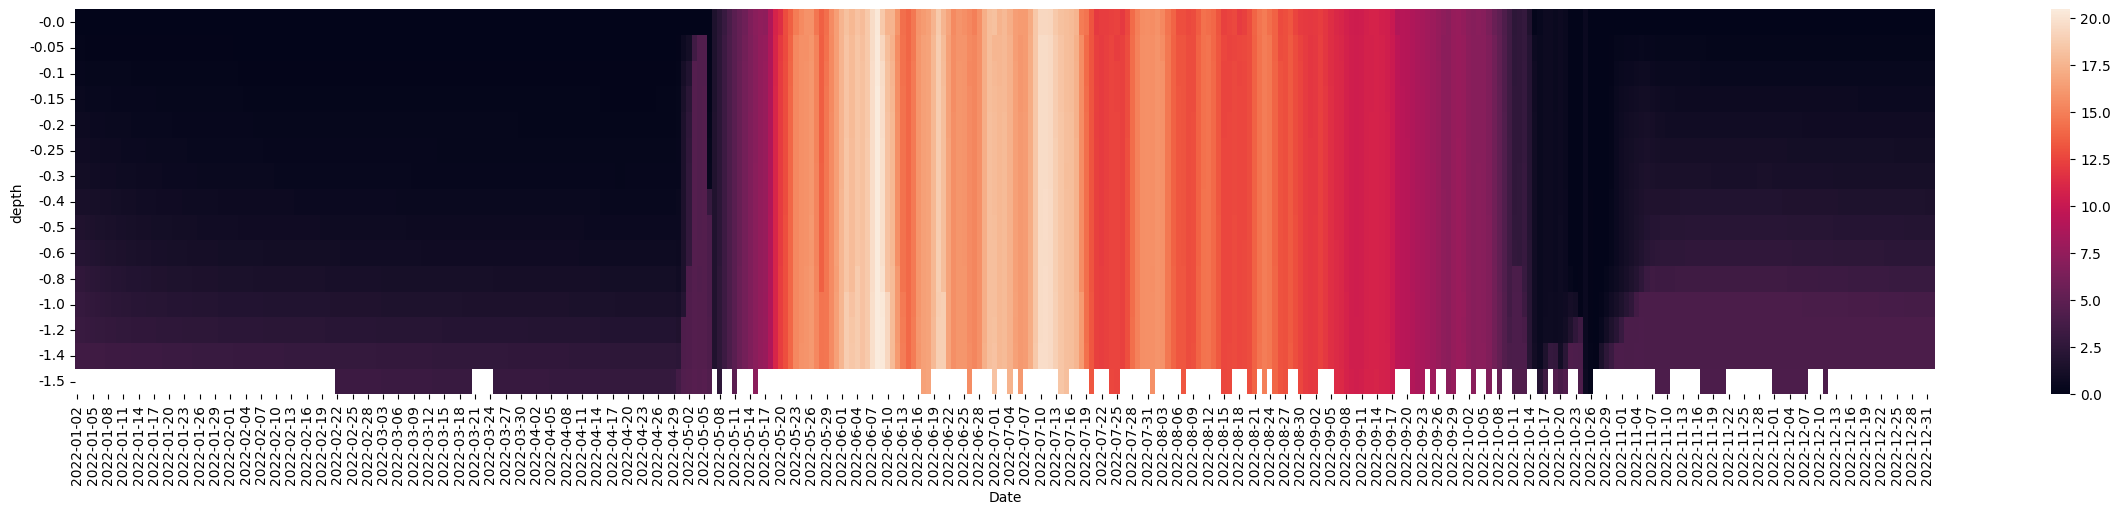

In [27]:
pd.plotting.register_matplotlib_converters()
burned_water_temps_df_filt=burned_vars_df.loc[(burned_vars_df['run_name']==0)&(burned_vars_df['t_water']!=-999)][['Date', 'depth', 't_water']].groupby(by=['Date', 'depth']).mean()
burned_water_temps_df_filt = burned_water_temps_df_filt.reset_index()
burned_water_temps_df_filt['Date'] = pd.to_datetime(burned_water_temps_df_filt['Date'])
burned_water_temps_df_filt['Date'] = burned_water_temps_df_filt['Date'].dt.date


pivot = burned_water_temps_df_filt.pivot(index='depth', columns='Date', values='t_water')
fig, ax = plt.subplots(1,1,figsize=(30,5))

sns.heatmap(pivot, cmap='rocket', ax=ax)

plt.gca().invert_yaxis()

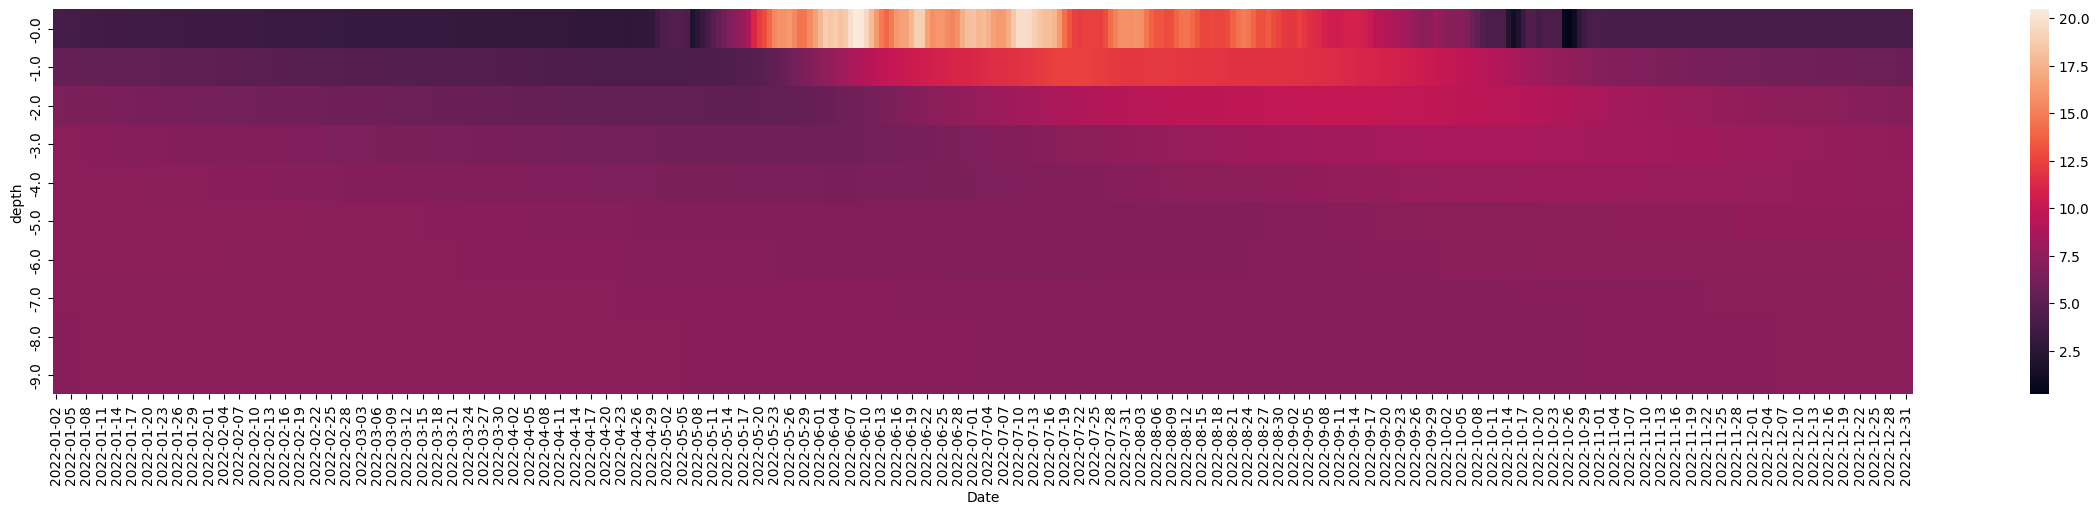

In [28]:
pd.plotting.register_matplotlib_converters()
burned_soil_temps_df_filt=burned_soil_temps_df.loc[(burned_soil_temps_df['run_name']==0)&(burned_soil_temps_df['t_soil']!=-999)][['Date', 'depth', 't_soil']]
burned_soil_temps_df_filt['Date'] = pd.to_datetime(burned_soil_temps_df_filt['Date'])
burned_soil_temps_df_filt['Date'] = burned_soil_temps_df_filt['Date'].dt.date

pivot = burned_soil_temps_df_filt.pivot(index='depth', columns='Date', values='t_soil')
fig, ax = plt.subplots(1,1,figsize=(30,5))

sns.heatmap(pivot, cmap='rocket', ax=ax)

plt.gca().invert_yaxis()



In [29]:
burned_vars_df[(burned_vars_df['t_water']!=-999) & (burned_vars_df['year']==2022) & (burned_vars_df['month']==1) & (burned_vars_df['day']==1)]

,year,month,day,hour,integration_time,depth,t_water,Date,co2_water,ch4_water,...,dD (VSMOW),a250,A254,a350,a375,S_275_295,S_R,SUVA,CH4_mol_m3,DO_mol_m3


In [30]:
burned_soil_temps_df.loc[(burned_soil_temps_df['run_name']==0)&(burned_soil_temps_df['t_soil']!=-999)&(burned_soil_temps_df['Date']=='2022-01-01')]

,year,month,day,hour,integration_time,depth,t_soil,Date,run_name


In [31]:
def get_performance(df, model_var, obs_var):
    runs = []
    var_mae = []
    df.loc[df[obs_var]==-999, obs_var] = np.nan
    for run in df['run_name'].unique():
        runs.append(run)
        var_mae.append(mean_absolute_error(df.loc[(df['run_name']==run) & (~df[obs_var].isna()), obs_var], df.loc[(df['run_name']==run) & (~df[obs_var].isna()),model_var]))
    
    df_performance = pd.DataFrame({'run_name': runs, f'{model_var}_mae': var_mae})

    return df_performance


In [32]:
burned_vars_df['CO2_mol_m3']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
48173   NaN
48174   NaN
48175   NaN
48176   NaN
48177   NaN
Name: CO2_mol_m3, Length: 48178, dtype: float64

In [33]:
#burned_vars_df = burned_vars_df.loc[burned_vars_df['depth']==-1.0]

df_co2_comp = get_performance(burned_vars_df.loc[burned_vars_df['depth']==-1.0], 'co2_water', 'CO2_mol_m3')
co2_top_10 = df_co2_comp.sort_values(by='co2_water_mae')[:30]
co2_top = df_co2_comp.sort_values(by='co2_water_mae')[:1]

df_co2_comp_ub = get_performance(unburned_vars_df.loc[unburned_vars_df['depth']==-1.0], 'co2_water', 'CO2_mol_m3')
co2_top_10_ub = df_co2_comp_ub.sort_values(by='co2_water_mae')[:30]
co2_top_ub = df_co2_comp_ub.sort_values(by='co2_water_mae')[:1]

In [34]:
df_ch4_comp = get_performance(burned_vars_df.loc[burned_vars_df['depth']==-1.0], 'ch4_water', 'CH4_mol_m3')
ch4_top_10 = df_ch4_comp.sort_values(by='ch4_water_mae')[:20]
ch4_top = df_ch4_comp.sort_values(by='ch4_water_mae')[:1]

df_ch4_comp_ub = get_performance(unburned_vars_df.loc[unburned_vars_df['depth']==-1.0], 'ch4_water', 'CH4_mol_m3')
ch4_top_10_ub = df_ch4_comp_ub.sort_values(by='ch4_water_mae')[:20]
ch4_top_ub = df_ch4_comp_ub.sort_values(by='ch4_water_mae')[:1]

In [35]:
df_o2_comp = get_performance(burned_vars_df.loc[burned_vars_df['depth']==-1.0], 'o2_water', 'DO_mg_L')
o2_top_10 = df_o2_comp.sort_values(by='o2_water_mae')[:20]
o2_top = df_o2_comp.sort_values(by='o2_water_mae')[:1]

df_o2_comp_ub = get_performance(unburned_vars_df.loc[unburned_vars_df['depth']==-1.0], 'o2_water', 'DO_mg_L')
o2_top_10_ub = df_o2_comp_ub.sort_values(by='o2_water_mae')[:20]
o2_top_ub = df_o2_comp_ub.sort_values(by='o2_water_mae')[:1]

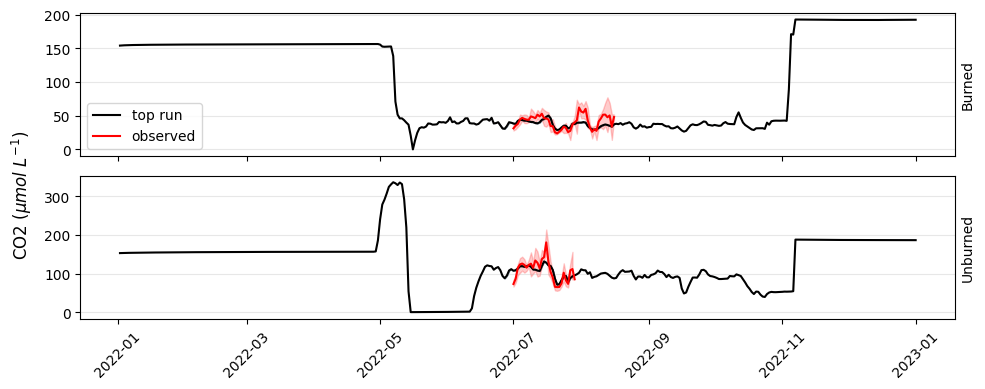

In [36]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top_10['run_name'])], 
             x='Date', y='co2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

#sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1)], 
#             x='Date', y='co2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 )  & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top['run_name'])], 
             x='Date', y='co2_water', label='top run', color='black', ax=axes[0])
sns.lineplot(data= burned_co2_obs, x='Date', y='CO2_mol_m3', label='observed', color='red', ax=axes[0], errorbar='pi')

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['co2_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], 
             x='Date', y='co2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['co2_water']!=-999 )  & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_ub['run_name'])], 
             x='Date', y='co2_water', color='black', ax=axes[1])
sns.lineplot(data= unburned_co2_obs, x='Date', y='CO2_mol_m3', color='red', ax=axes[1], errorbar='pi')

plt.xticks(rotation=45)
#axes[0].set_ylim(0,180)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position('right')
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

fig.supylabel(u'CO2 ($\u03bcmol$ $L^{-1}$)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_co2.jpg', dpi=300)
#axes[1].set_ylim(0,220)

In [34]:
#sns.lineplot(data= burned_vars_df[(burned_vars_df['doc_water']!=-999) & (burned_vars_df['depth']==-1)], x='Date', y='doc_water', hue = 'run_name', legend=False, linewidth=0.3)
#sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red')
#plt.xticks(rotation=45)


In [42]:
burned_vars_df.columns

Index(['year', 'month', 'day', 'hour', 'integration_time', 'depth', 't_water',
       'Date', 'co2_water', 'ch4_water', 'o2_water', 'doc_water', 'pocl_water',
       'pocd_water', 'phosph_water', 'poc_water', 'run_name', 'datetime',
       'Time', 'Battery_Voltage_Avg', 'PTemp_Avg_degC', 'CO2_meas_ppm',
       'CO2_meas_RA_ppm', 'WaterTemp_meas_degC', 'PAR', 'CO2_mol_m3', 'sample',
       'coords_west', 'coords_east', 'system_type', 'burn_history',
       'burn_year', 'CH4_ppm', 'CO2_ppm', 'CN_filt_vol', 'temp_C',
       'pressure_atm', 'DO_mg_L', 'cond_uS_cm', 'pH', 'ORP', 'TOC (mg/L)',
       'TN (mg/L)', 'd18O (VSMOW)', 'dD (VSMOW)', 'a250', 'A254', 'a350',
       'a375', 'S_275_295', 'S_R', 'SUVA', 'CH4_mol_m3', 'DO_mol_m3'],
      dtype='object')

In [56]:
burned_sample_comp = burned_vars_df.loc[(~burned_vars_df['CH4_mol_m3'].isna()) & (burned_vars_df['depth']==-1)][['Date', 'ch4_water', 'o2_water', 'DO_mg_L', 'CH4_mol_m3', 'depth']].groupby(by='Date').mean()
unburned_sample_comp = unburned_vars_df.loc[(~unburned_vars_df['CH4_mol_m3'].isna()) & (unburned_vars_df['depth']==-1)][['Date', 'ch4_water', 'o2_water', 'DO_mg_L', 'CH4_mol_m3', 'depth']].groupby(by='Date').mean()
burned_sample_comp['pond'] = 'burned' 
unburned_sample_comp['pond'] = 'unburned'
sample_comp = pd.concat([burned_sample_comp, unburned_sample_comp]).reset_index()

In [59]:
sample_comp_melt=pd.melt(sample_comp, id_vars=['Date', 'pond'])

In [60]:
sample_comp_melt

,Date,pond,variable,value
0,2022-07-09,burned,ch4_water,0.439631
1,2022-07-17,burned,ch4_water,0.503811
2,2022-07-24,burned,ch4_water,0.949271
3,2022-08-19,burned,ch4_water,1.002586
4,2022-08-27,burned,ch4_water,0.792457
...,...,...,...,...
65,2022-07-22,unburned,depth,-1.000000
66,2022-08-15,unburned,depth,-1.000000
67,2022-08-22,unburned,depth,-1.000000
68,2022-08-28,unburned,depth,-1.000000


Text(0, 0.5, 'CH4 (umol/L)')

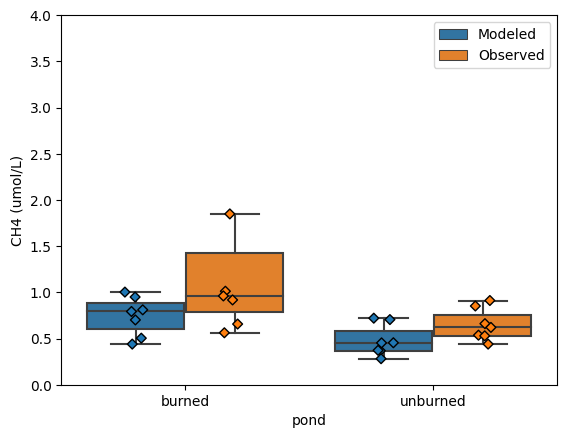

In [87]:
sns.boxplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'ch4_water') | (sample_comp_melt['variable'] == 'CH4_mol_m3')], 
            x='pond', y='value', hue='variable')
sns.stripplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'ch4_water') | (sample_comp_melt['variable'] == 'CH4_mol_m3')], 
            x='pond', y='value', hue='variable', dodge=True, marker="D", edgecolor="black", linewidth=1, legend=False)
plt.ylim(0,4)
L=plt.legend()
L.get_texts()[0].set_text('Modeled')
L.get_texts()[1].set_text('Observed')

plt.ylabel('CH4 (umol/L)')

Text(0, 0.5, 'O2 (mg/L)')

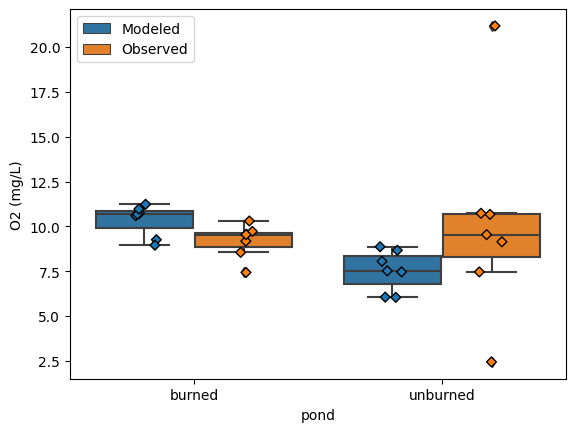

In [85]:
sns.boxplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'o2_water') | (sample_comp_melt['variable'] == 'DO_mg_L')], 
            x='pond', y='value', hue='variable')
sns.stripplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'o2_water') | (sample_comp_melt['variable'] == 'DO_mg_L')], 
            x='pond', y='value', hue='variable', dodge=True, marker="D", edgecolor="black", linewidth=1, legend=False)

L=plt.legend()
L.get_texts()[0].set_text('Modeled')
L.get_texts()[1].set_text('Observed')

plt.ylabel('O2 (mg/L)')

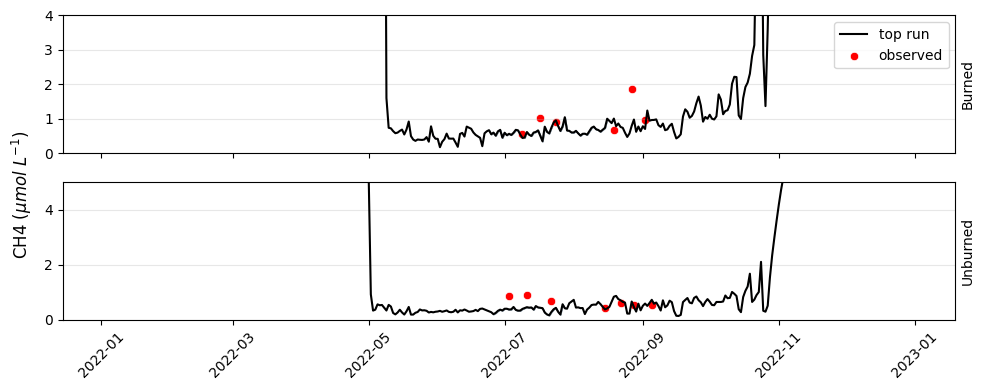

In [41]:
#sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999)  & (burned_vars_df['depth']==-1)], x='Date', y='ch4_water', hue = 'run_name', legend=False,linewidth=0.3)
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data = burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(ch4_top_10['run_name'])], 
             x='Date', y='ch4_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(ch4_top['run_name'])], 
             x='Date', y='ch4_water', label='top run', color='black', ax=axes[0])
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='CH4_mol_m3', label='observed', color='red', ax=axes[0])

axes[0].set_ylim(0,4)
axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

#sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1)], 
#             x='Date', y='ch4_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(ch4_top_10_ub['run_name'])], 
             x='Date', y='ch4_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(ch4_top_ub['run_name'])], 
             x='Date', y='ch4_water',  color='black', legend=False, ax=axes[1])
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='Date', y='CH4_mol_m3', color='red', ax=axes[1])

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xlabel('')
axes[1].set_ylim(0,5.0)

plt.xticks(rotation=45)
fig.supylabel(u'CH4 ($\u03bcmol$ $L^{-1}$)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_ch4.jpg', dpi=300)

In [43]:
burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(ch4_top_10['run_name'])]

,year,month,day,hour,integration_time,depth,t_water,Date,co2_water,ch4_water,...,dD (VSMOW),a250,A254,a350,a375,S_275_295,S_R,SUVA,CH4_mol_m3,DO_mol_m3
11,2022,1,2,12.0,1.0,-1.0,3.110065,2022-01-02,153.939186,44.776788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,2022,1,3,12.0,2.0,-1.0,2.910465,2022-01-03,154.191914,45.654688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,2022,1,4,12.0,3.0,-1.0,2.770260,2022-01-04,154.369789,46.677502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,2022,1,5,12.0,4.0,-1.0,2.662292,2022-01-05,154.506963,47.840688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,2022,1,6,12.0,5.0,-1.0,2.575103,2022-01-06,154.617862,49.242910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48104,2022,12,28,12.0,361.0,-1.0,3.734570,2022-12-28,192.170115,450.980639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48121,2022,12,29,12.0,362.0,-1.0,3.724136,2022-12-29,192.183264,456.356664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48138,2022,12,30,12.0,363.0,-1.0,3.712508,2022-12-30,192.198005,461.314856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48155,2022,12,31,12.0,364.0,-1.0,3.688281,2022-12-31,192.231559,465.735912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


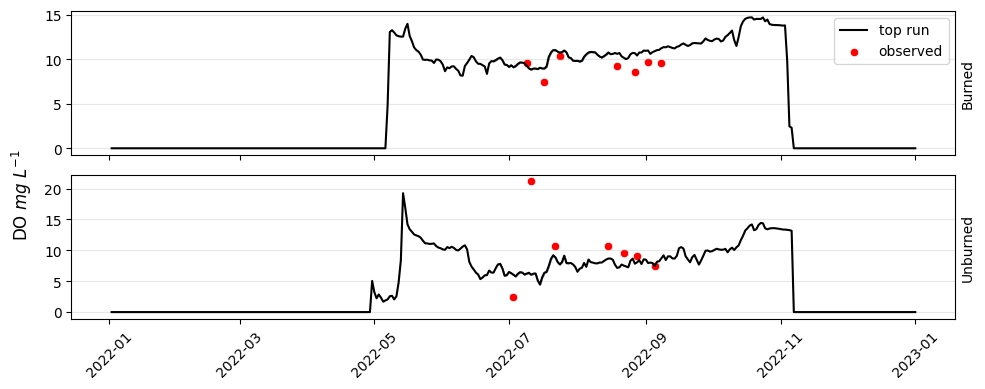

In [42]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1.0) & burned_vars_df['run_name'].isin(o2_top_10['run_name'])], 
             x='Date', y='o2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(o2_top['run_name'])], 
             x='Date', y='o2_water', label='top run', color='black', ax=axes[0])
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='DO_mg_L', label='observed', color='red', ax=axes[0])
axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)


sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['run_name'].isin(o2_top_10_ub['run_name'])],
             x='Date', y='o2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['co2_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(o2_top_ub['run_name'])], 
             x='Date', y='o2_water', color='black', ax=axes[1])
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='Date', y='DO_mg_L', color='red', ax=axes[1])
axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xlabel('')

plt.xticks(rotation=45)
fig.supylabel('DO $mg$ $L^{-1}$')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_do.jpg', dpi=300)
#plt.ylim(0,10)

(array([18993., 19052., 19113., 19174., 19236., 19297., 19358.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01')])

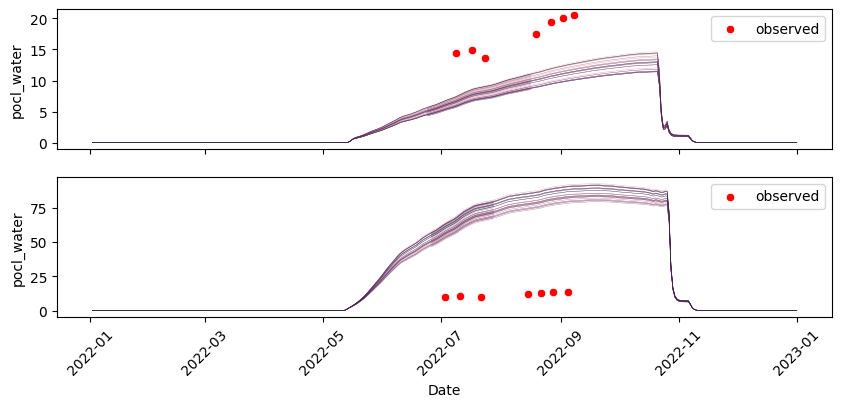

In [37]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['pocl_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(o2_top_10['run_name'])], x='Date', y='pocl_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[0])
plt.xticks(rotation=45)

sns.lineplot(data=unburned_vars_df[(unburned_vars_df['pocl_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(o2_top_10_ub['run_name'])], x='Date', y='pocl_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])

sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[1])
plt.xticks(rotation=45)

(array([18993., 19052., 19113., 19174., 19236., 19297., 19358.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01')])

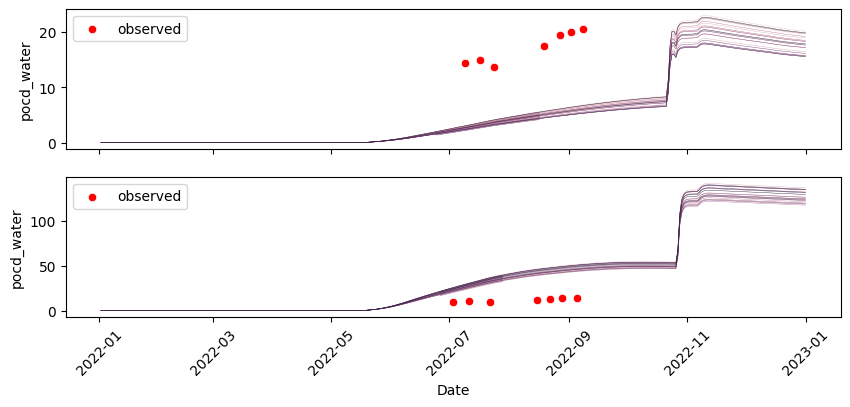

In [38]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['pocd_water']!=-999 ) & (burned_vars_df['depth']==-1.0) & burned_vars_df['run_name'].isin(o2_top_10['run_name'])], x='Date', y='pocd_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[0])
plt.xticks(rotation=45)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['pocd_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['run_name'].isin(o2_top_10_ub['run_name'])], x='Date', y='pocd_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])

sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[1])
plt.xticks(rotation=45)

(array([18993., 19052., 19113., 19174., 19236., 19297., 19358.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01')])

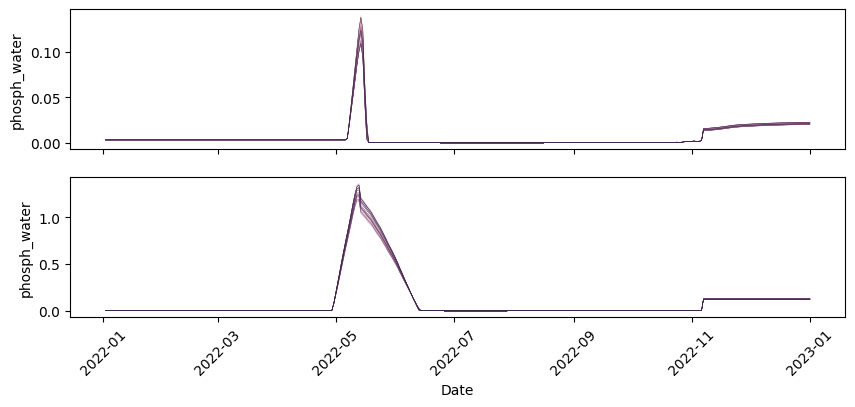

In [39]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['phosph_water']!=-999 ) & (burned_vars_df['depth']==-1.0) & burned_vars_df['run_name'].isin(o2_top_10['run_name'])], x='Date', y='phosph_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
plt.xticks(rotation=45)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['phosph_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['run_name'].isin(o2_top_10_ub['run_name'])], x='Date', y='phosph_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)

<Axes: xlabel='Date', ylabel='pH'>

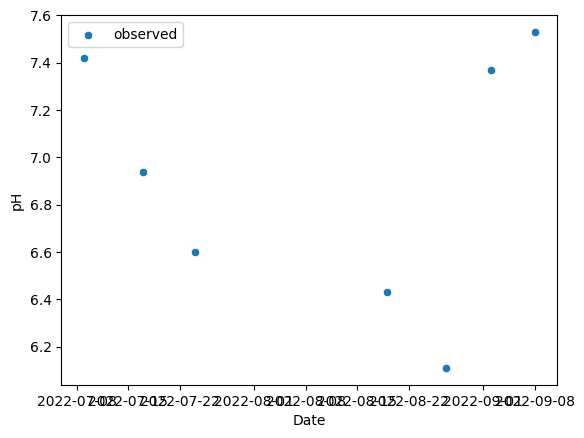

In [40]:
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='pH', label='observed')

In [41]:
burned_vars_df = burned_vars_df.replace(-999, np.nan)
burned_run_summary = burned_vars_df[['run_name', 't_water', 'co2_water', 'ch4_water', 'o2_water', 'doc_water']].groupby(by='run_name').mean().reset_index()
burned_sensitivity_df = pd.merge(burned_run_summary, burned_sample_matrix, on='run_name')

unburned_vars_df = unburned_vars_df.replace(-999, np.nan)
unburned_run_summary = unburned_vars_df[['run_name', 't_water', 'co2_water', 'ch4_water', 'o2_water', 'doc_water']].groupby(by='run_name').mean().reset_index()
unburned_sensitivity_df = pd.merge(unburned_run_summary, unburned_sample_matrix, on='run_name')

In [42]:
#co2_top_10['run_name'] = co2_top_10['run_name']
#ch4_top_10['run_name'] = ch4_top_10['run_name']
#o2_top_10['run_name'] = o2_top_10['run_name']

/home/amullen/anaconda3/envs/lake_modeling/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



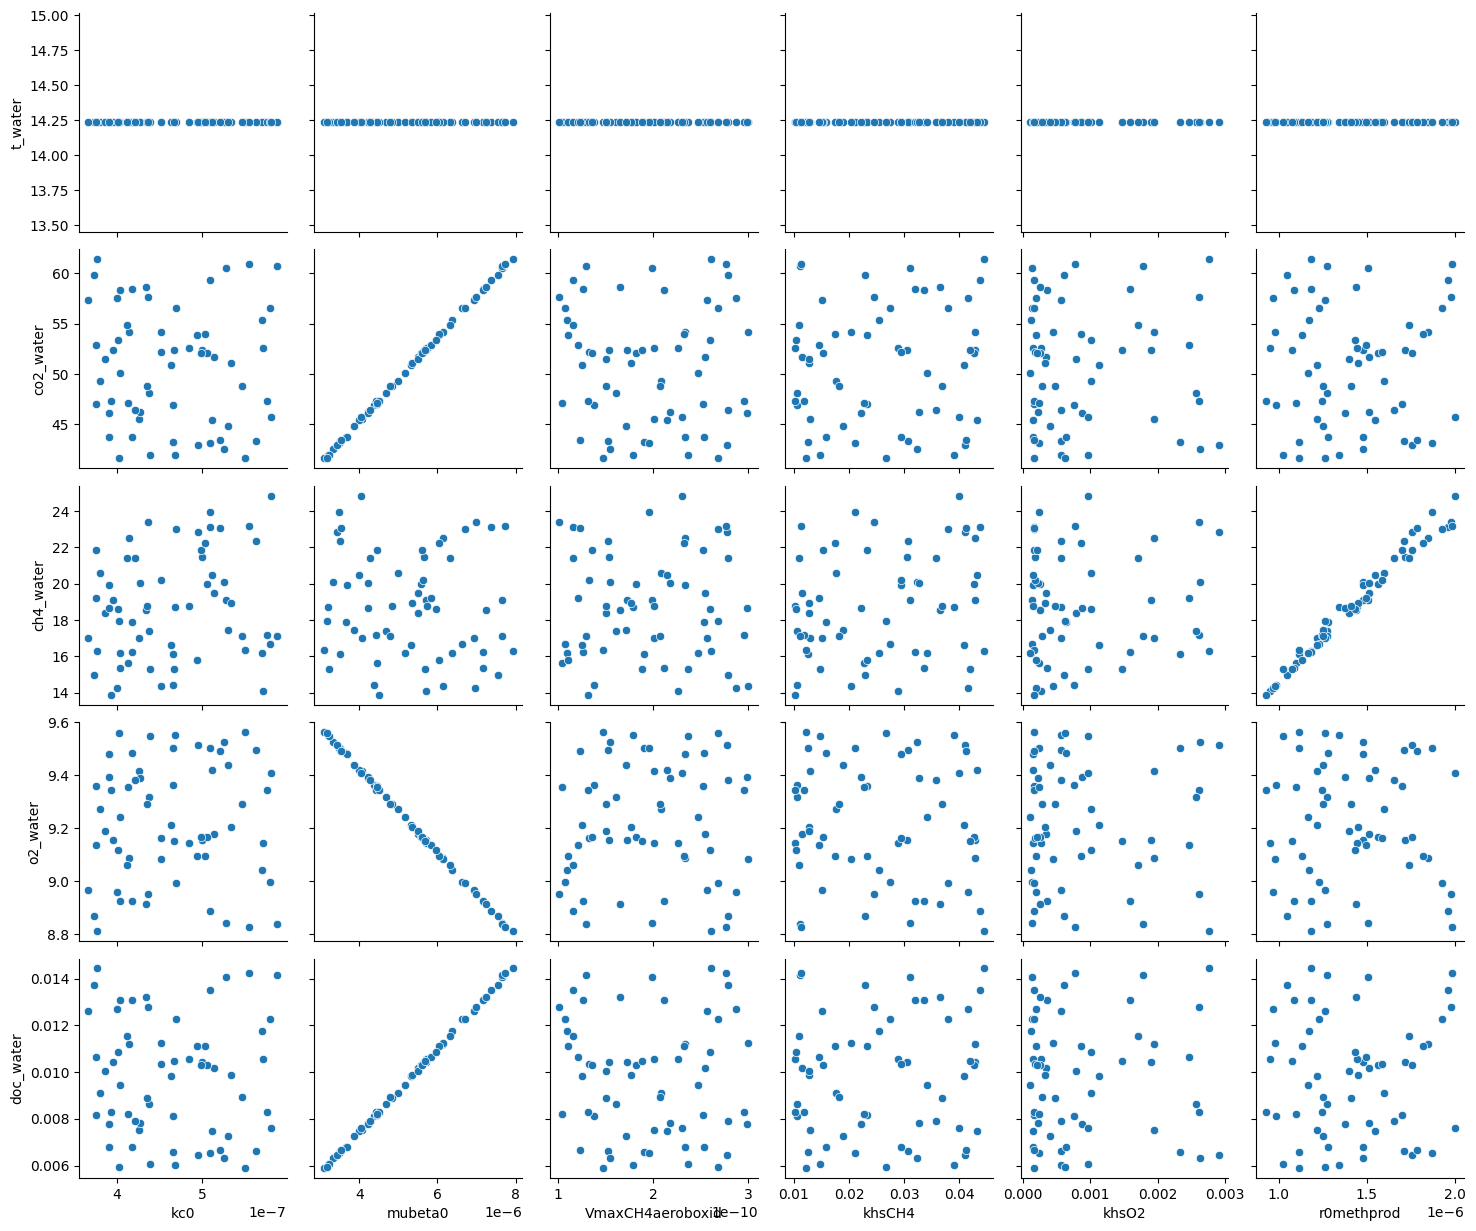

In [43]:
sns.pairplot(burned_sensitivity_df, x_vars=['kc0', 'mubeta0', 'VmaxCH4aeroboxid', 'khsCH4', 'khsO2',
       'r0methprod'], y_vars=['t_water', 'co2_water', 'ch4_water', 'o2_water',
       'doc_water']) 

/home/amullen/anaconda3/envs/lake_modeling/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



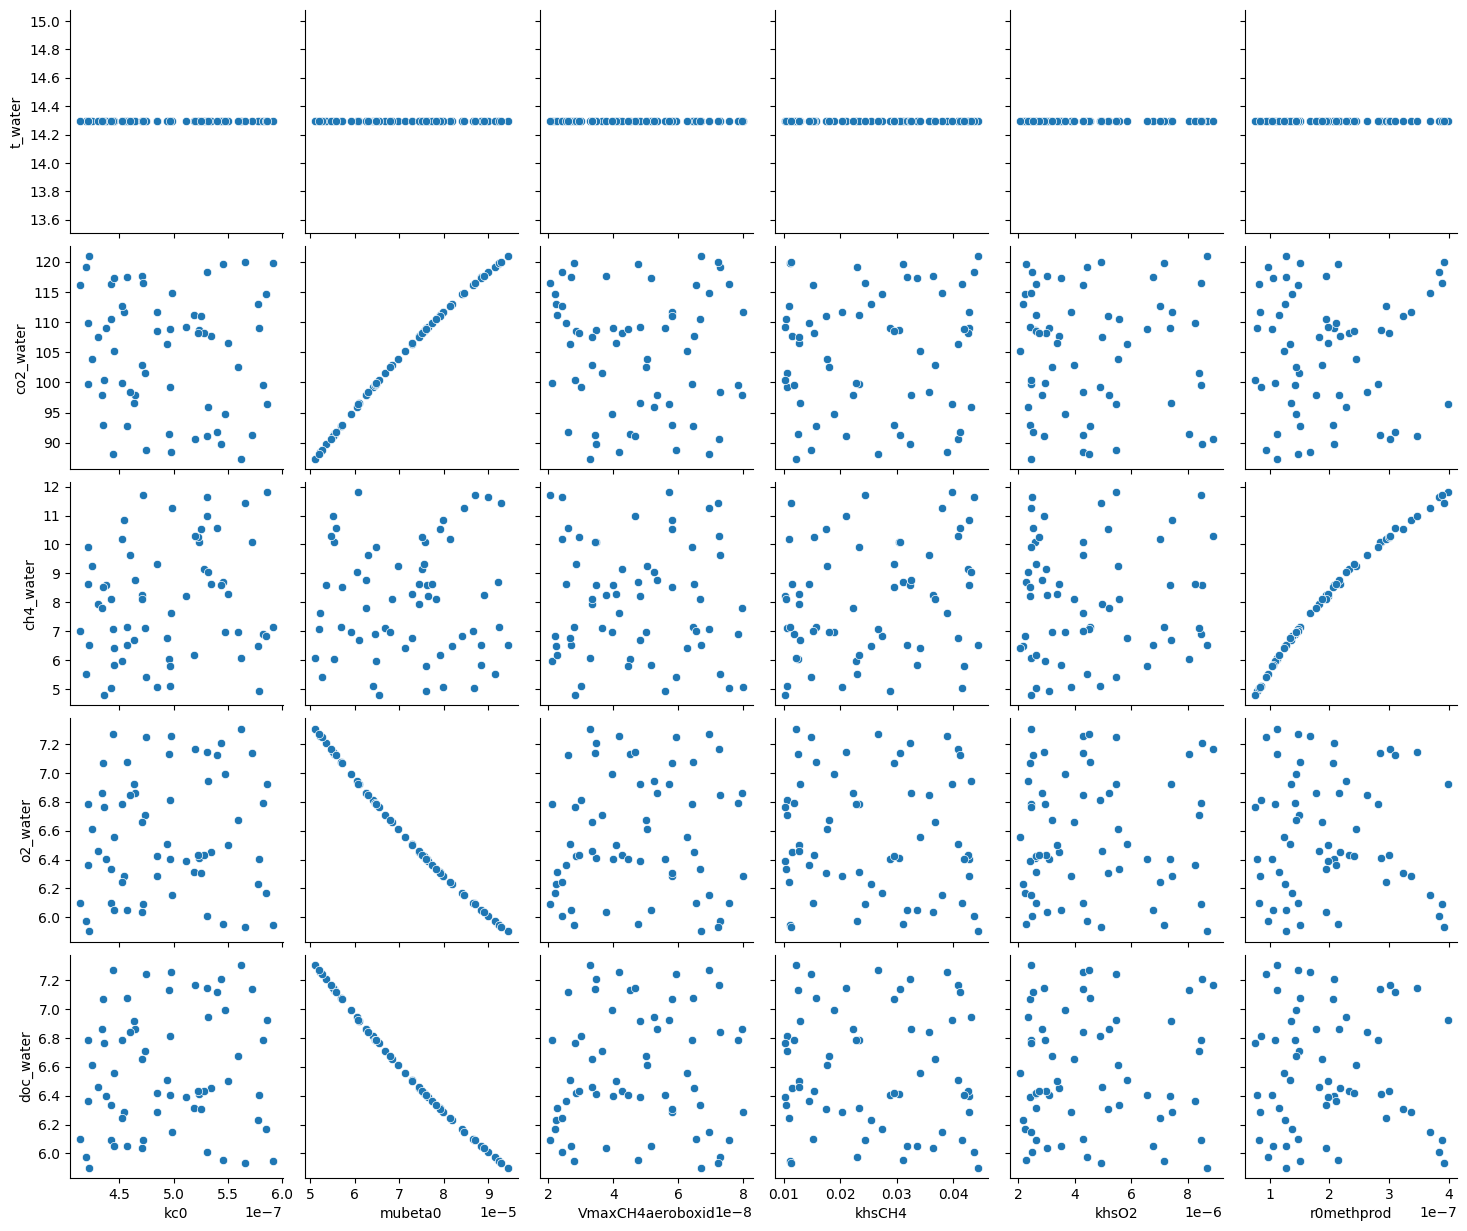

In [44]:
sns.pairplot(unburned_sensitivity_df, x_vars=['kc0', 'mubeta0', 'VmaxCH4aeroboxid', 'khsCH4', 'khsO2',
       'r0methprod'], y_vars=['t_water', 'co2_water', 'ch4_water', 'o2_water',
       'doc_water'])

In [45]:
burned_sensitivity_df.loc[burned_sensitivity_df['run_name'].isin(co2_top['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,doc_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
7,8,14.23626,46.898423,14.432098,9.362268,0.008112,4.663593e-07,0.000004,1.380470e-10,0.010559,0.00076,9.825120e-07


In [46]:
burned_sensitivity_df.loc[burned_sensitivity_df['run_name'].isin(ch4_top['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,doc_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
16,17,14.23626,48.113855,17.380175,9.316085,0.008627,4.377355e-07,0.000005,1.605669e-10,0.010556,0.002569,0.000001


In [47]:
burned_sensitivity_df.loc[burned_sensitivity_df['run_name'].isin(o2_top['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,doc_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
48,49,14.23626,57.344996,16.998422,8.965799,0.012628,3.661383e-07,0.000007,2.563161e-10,0.01517,0.000563,0.000001


In [48]:
unburned_sensitivity_df.loc[unburned_sensitivity_df['run_name'].isin(co2_top_ub['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,doc_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
52,53,14.292968,109.855599,8.645702,6.363967,6.363967,4.212760e-07,0.000077,2.554646e-08,0.014493,0.000008,2.113301e-07


In [49]:
unburned_sensitivity_df.loc[unburned_sensitivity_df['run_name'].isin(ch4_top_ub['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,doc_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
56,57,14.292968,96.39995,11.799045,6.92503,6.92503,5.855968e-07,0.000061,5.728169e-08,0.039912,0.000005,3.983425e-07


In [50]:
unburned_sensitivity_df.loc[unburned_sensitivity_df['run_name'].isin(o2_top_ub['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,doc_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
24,25,14.292968,87.319449,6.07151,7.306782,7.306782,5.621635e-07,0.000051,3.278060e-08,0.012094,0.000002,1.123618e-07
